<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import multiprocessing as mp
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11149

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

0    3312
2    2543
4    2370
5    1656
1    1548
6    1370
3     574
Name: state, dtype: int64

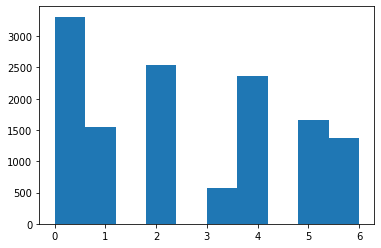

In [7]:
plt.hist(states.state);

In [8]:
TRIM = 0.02
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 112


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1973, 1, 19),
 datetime.date(2023, 1, 7),
 datetime.date(2013, 1, 9),
 2)

In [13]:
START, TODAY

(datetime.date(1973, 1, 19), datetime.date(2023, 1, 7))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (data[col][data[col].notnull()].to_numpy()[-1]
            < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def trim_returns(returns, trim):
    lower_q = trim / 2
    upper_q = 1 - lower_q
    qs = np.quantile(returns, q=[lower_q, upper_q])
    returns = returns[((returns > qs[0]) & (returns < qs[1]))]
    return returns

In [22]:
def get_annualized_daily_return(returns, trim=0.02):
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    if trim:
        returns = trim_returns(returns, trim)
    amt = returns.cumprod()
    n = len(returns)
    if n > 2:
        daily_return = amt[-1]**(1/max(n - 1, 1))
    else:
        daily_return = 0
    return daily_return

In [23]:
def get_daily_annualized_return_by_state(data, trim=0.02):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state], trim=trim)
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [24]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [25]:
def process_batch(batch, min_start, trim=0.02):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data, trim)
    return state_dars

In [26]:
# TODO: multiprocess
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACEL ADUS AGTC ALGS AMK APAC ARES ASTC AUY AZZ BCTF BHK BLL BOXL BSX BZC CBB CDE CFK CIFR CLPT CNL CPAK CRTD CTRA CXH DCNT DIAX DOW DUKB ECOM ELBO ENTX ESP EXAC FCEL FHB FMN FRME FTW GCO GHIX GMRK GRND GWW HDTV HLNE HRMY HYSL IDTI IMMU INVO ISR JE JWN KLXE KVHI LENB LMAT LSPN MANT MDC MGAM MLAB MORF MSNQ MXC NBXZ NFLD NN NSCN NVG OBLG OMN OSAT PAQC PDSN PHAT PLTR PPSI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_96617/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_96617/1541653759.py:5: RuntimeWarning: invalid value encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


PSNY PZE RAPT REST RMED RSG SAJA SCMM SFSF SINO SMMF SOLO SRAX STIX SWAG TAYD TETC TKR TPGH TSAT TXCO UMRX UXJ VIFL VOXW VVX WFII WPG XAN XWEL ZKID 

In [27]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000234,0.997648,1.001118,1.027542,1.002051,1.001466,1.002529,1.002027
AA,1.000369,0.997306,1.001385,1.001634,1.000546,1.001103,1.001067,1.001339
AAIC,0.999366,0.997429,1.000201,1.023690,1.002162,1.001102,1.000725,1.000173
AAL,0.999872,0.995257,1.002144,1.017530,1.003056,1.001087,1.001435,1.001413
AAME,0.999741,0.997367,1.000605,1.001051,1.002200,1.000293,1.001165,0.999765


In [28]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000136,0.998751,0.996444,0.000000,1.006403,1.002120,1.001897,0.998797
ZTR,1.000336,0.999375,1.000641,1.001746,1.000912,1.000502,1.000912,1.000814
ZUMZ,1.000255,0.997380,1.001523,0.978434,1.002864,1.001449,1.001344,1.000799
ZWS,1.000411,0.996927,1.000296,0.000000,1.001665,1.001014,1.002311,1.001707
ZYXI,1.000793,1.000907,1.001046,0.992291,1.002987,0.998193,1.000981,1.003260


In [29]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [30]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [31]:
CURRENT_STATE# = 0

0

In [32]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.8*df[f'dar_{CURRENT_STATE}'] 
        + 0.2*df[f'dar_{CURRENT_STATE + 1}'])
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.2*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df[f'dar_{CURRENT_STATE - 1}'])
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.8*df[f'dar_{CURRENT_STATE}']
        + 0.2*df[f'dar_{CURRENT_STATE - 1}'])
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
OMQS,0.999199,1.000751,1.003508,0.000000,0.999235,0.995340,0.996217,0.999370,1.001302
ZYXI,1.000793,1.000907,1.001046,0.992291,1.002987,0.998193,1.000981,1.003260,1.000935
GCBC,1.000633,1.001027,1.000433,0.998567,1.000453,1.000077,1.000634,1.000557,1.000908
FNV,1.000678,1.000742,1.001167,1.021081,1.000034,1.000828,0.999955,1.000482,1.000827
MTA,1.000329,1.000866,1.000498,0.000000,1.001591,0.999759,0.998256,1.000466,1.000793


In [33]:
df.mean(), df.median()

(dar         1.000128
 dar_0       0.998179
 dar_1       1.000634
 dar_2       0.940000
 dar_3       1.001250
 dar_4       1.000865
 dar_5       1.001081
 dar_6       1.000273
 weighted    0.998670
 dtype: float64,
 dar         1.000288
 dar_0       0.998399
 dar_1       1.000748
 dar_2       1.002972
 dar_3       1.001198
 dar_4       1.000981
 dar_5       1.001089
 dar_6       1.000978
 weighted    0.998885
 dtype: float64)

In [63]:
always_exclude = ['EP', 'NXN', 'NXP']
exclude = {
    0: ['AGNC', 'BGS', 'FMN', 'GUT', 'HMY', 'KSM', 'MED', 'MRTI', 'OMQS', 'UTHR', 'ZYXI'],
    #'CGAU', 'CTSH', 'MRTI', 'ORLY', ], 
    1: [],
    7: []}

In [64]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [65]:
print(sorted(best_weighted))
#sorted(best_weighted)

['ABST', 'AGI', 'CEF', 'CGAU', 'CZFS', 'DGX', 'FNV', 'GCBC', 'IEI', 'IIM', 'LFMD', 'MHN', 'MIN', 'MIY', 'MMU', 'MTA', 'NAZ', 'NEN', 'NPV', 'NUO']


In [73]:
DOLLAR_AMT = 100_129
FRAC_IN = 0.5309
current = df.loc[best_weighted]
current['w'] = (current.weighted - 1) 
current.w = current.w / current.w.sum()
current['amt'] = (DOLLAR_AMT * FRAC_IN * current.w).round().astype(int)
current.sort_index()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted,w,amt
ABST,1.000389,1.000413,0.999951,0.997245,1.002633,0.999632,0.999650,1.001373,1.000321,0.041084,2184
AGI,1.000558,1.000559,1.000057,1.022512,1.001089,1.001520,1.000139,0.999868,1.000459,0.058818,3127
CEF,1.000157,1.000320,1.000185,1.000650,0.999658,1.000323,0.999698,0.999890,1.000293,0.037593,1998
CGAU,1.000459,1.000225,1.001762,1.017575,1.001411,1.001231,0.999399,0.999111,1.000532,0.068220,3626
CZFS,1.000403,1.000367,1.000697,0.000000,0.999492,1.000196,1.000351,1.000558,1.000433,0.055465,2948
DGX,1.000669,1.000233,1.000669,0.999686,1.001271,1.001132,1.000658,1.001048,1.000320,0.041026,2181
FNV,1.000678,1.000742,1.001167,1.021081,1.000034,1.000828,0.999955,1.000482,1.000827,0.106020,5636
GCBC,1.000633,1.001027,1.000433,0.998567,1.000453,1.000077,1.000634,1.000557,1.000908,0.116380,6187
IEI,1.000104,1.000245,1.000175,0.997881,1.000037,0.999985,0.999989,0.999968,1.000231,0.029637,1575
IIM,1.000229,1.000131,1.000529,0.999521,1.000545,1.000388,1.000196,0.999861,1.000210,0.026958,1433


In [67]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [68]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,ABST,AGI,CEF,CGAU,CZFS,DGX,FNV,GCBC,IEI,IIM,LFMD,MHN,MIN,MIY,MMU,MTA,NAZ,NEN,NPV,NUO
Date,,,,,,,,,,,,,,,,,,,,
2022-12-30,10.44,10.11,17.930000,5.18,76.720001,156.440002,136.479996,57.419998,114.889999,12.05,1.94,10.27,2.76,11.09,10.07,4.91,11.16,71.000000,11.16,12.69
2023-01-03,10.75,10.36,18.000000,5.36,77.000000,155.770004,138.149994,58.299999,115.230003,12.06,1.89,10.35,2.78,11.28,10.14,4.95,11.32,70.989998,11.38,12.91
2023-01-04,11.08,10.85,18.080000,5.57,76.000000,154.580002,141.970001,56.040001,115.680000,12.18,1.90,10.42,2.78,11.38,10.22,5.17,11.30,70.449997,11.50,12.92
2023-01-05,11.65,10.78,17.870001,5.65,75.000000,154.500000,139.850006,54.349998,115.489998,12.03,1.90,10.39,2.78,11.34,10.15,5.11,11.26,70.040001,11.57,12.90
2023-01-06,11.11,10.86,18.219999,5.78,75.959999,155.639999,139.800003,54.380001,116.489998,12.28,1.93,10.46,2.80,11.44,10.25,5.21,11.29,69.680000,11.71,12.96


In [69]:
data = pd.concat([data, states], axis=1)

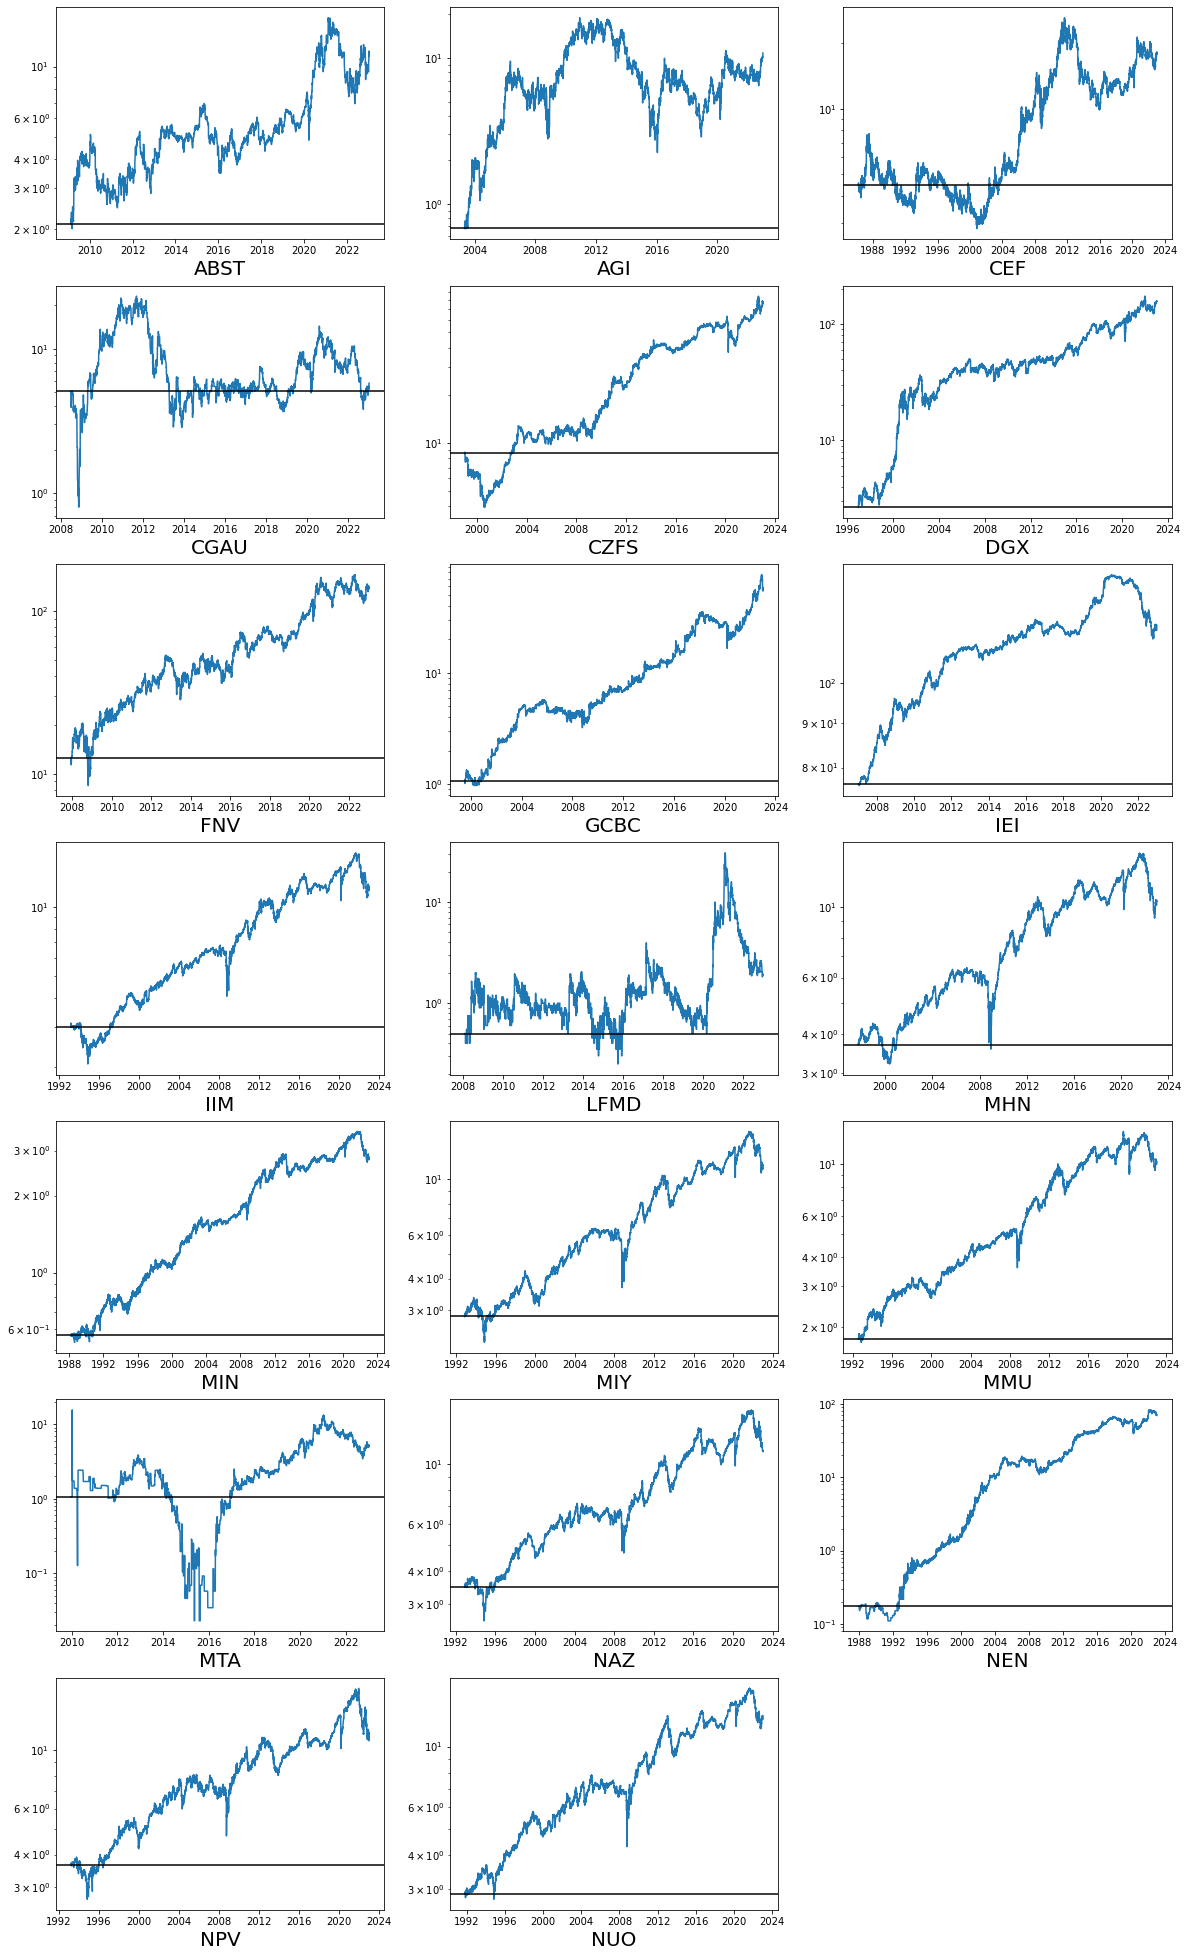

In [70]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    x = data[sym]
    x = x[x.notnull()]
    plt.subplot(7, 3, i + 1)
    plt.plot(x)
    plt.axhline(y=x[0], color='k')
    plt.xlabel(sym)
    plt.yscale('log');

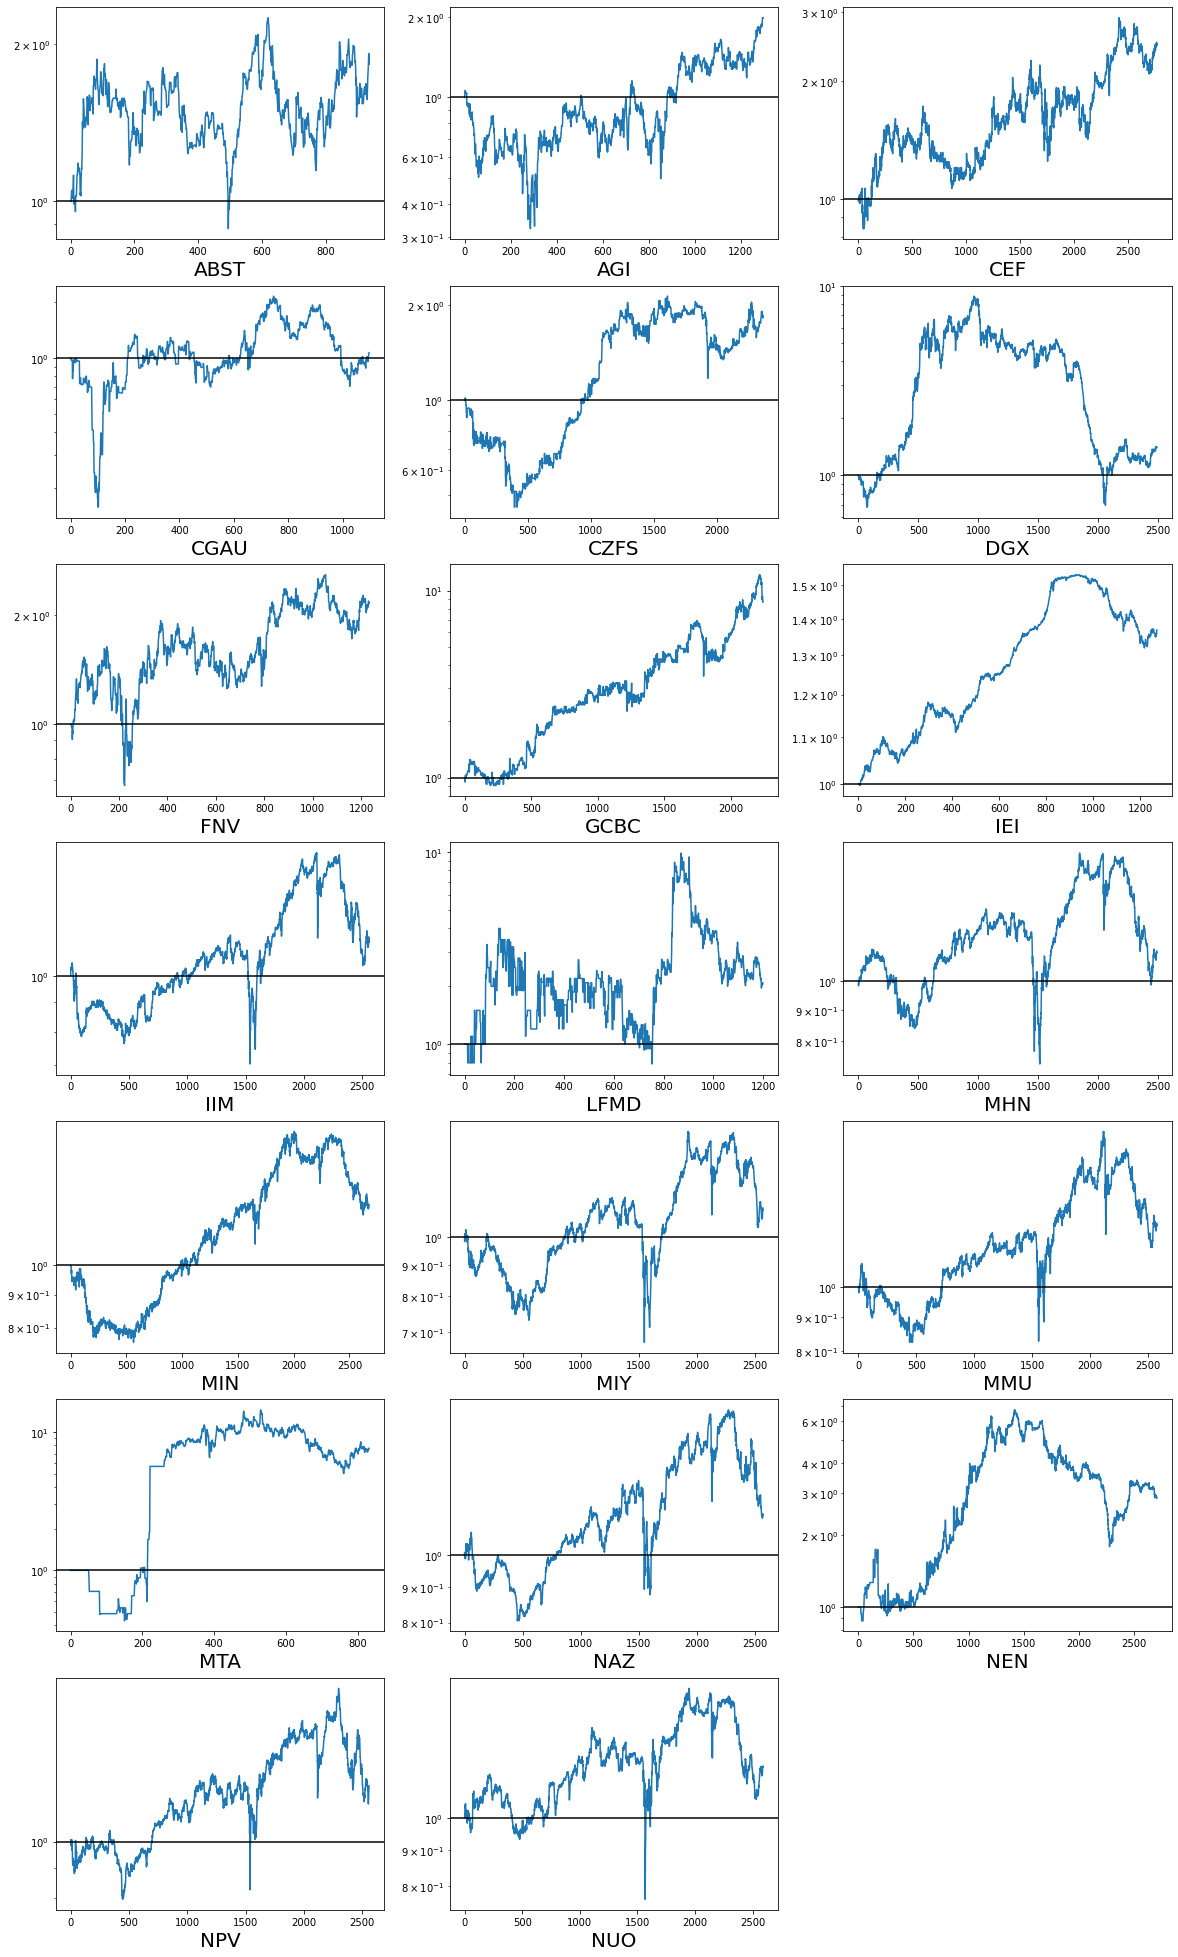

In [71]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.axhline(y=dr[0], color='k')
    plt.yscale('log')
    plt.xlabel(sym);